# Imports

In [1]:
!pip install torchmetrics matplotlib seaborn scikit-learn

  Using cached torchmetrics-1.3.2-py3-none-any.whl.metadata (19 kB)
  Using cached matplotlib-3.8.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.8 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached scikit_learn-1.4.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
  Using cached lightning_utilities-0.11.2-py3-none-any.whl.metadata (4.7 kB)
  Using cached contourpy-1.2.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.8 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.51.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (159 kB)
  Using cached kiwisolver-1.4.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.4 kB)
  Using cached pyparsing-3.1.2-py3-none-any.whl.metadata (5.1 kB)
  Using cached pandas-2.2.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (19 kB)
  Using cac

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchmetrics

from torch.utils.data import Dataset ,DataLoader, WeightedRandomSampler
from torch.utils.data.dataset import Subset
from torch.utils.data import random_split
from torchvision import transforms
from PIL import Image

import os
import numpy as np
import json
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score

import seaborn as sns

# Dataset Class Definition for Non-Series Dataset

In this section, we define a custom dataset class `AlzheimerDataset` for handling the Alzheimer's MRI images dataset. Each image in this dataset is treated as an individual sample. This class is crucial for loading the images and their corresponding labels efficiently during the training and evaluation of our deep learning models. It allows us to apply transformations to the dataset images and prepare them for input into the neural network.

### Data Augmentation and DataLoader Preparation

In this section, we initialize the dataset and then apply data augmentation techniques to increase the diversity of our dataset, which can lead to better model generalization. After initializing the Alzheimer's dataset class, we split the dataset into training, validation, and test sets. To address the issue of class imbalance, we calculate class weights and utilize these weights to create a weighted sampler for the training data. Finally, we prepare DataLoader objects for each subset of the dataset to facilitate efficient data loading during the model training and evaluation phases.

To effectively handle class imbalance, we employ a weight rebalancing strategy that ensures less frequent classes are given more importance during training. This is accomplished through the following steps:

1. **Calculate Class Sample Counts**: We compute the number of samples for each class in the dataset. This count helps in identifying the extent of imbalance and determining the appropriate weight that each class should receive.

2. **Compute Class Weights**: For each class, the weight is calculated as the inverse of its sample count. This method assigns higher weights to less frequent classes, thus amplifying their presence during the training process.

3. **Assign Sample Weights**: Each sample in the dataset is then assigned a weight corresponding to its class weight. This results in a weighted distribution where the significance of each sample is adjusted according to its weight.

4. **Weighted Random Sampler**: In the training DataLoader, a WeightedRandomSampler is used with these sample weights. This sampler ensures that data batches are selected in a manner that reflects the assigned weights, providing more representation to underrepresented classes and mitigating the effects of class imbalance.

By applying these steps, we ensure that the training process accounts for all classes equitably, preventing the model from biasing towards the majority classes and thereby achieving a more balanced and accurate prediction across all classes.


In [3]:
class AlzheimerDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the image categories.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        categories = ['Mild Dementia', 'Moderate Dementia', 'Non Demented', 'Very mild Dementia']
        label_mapping = {category: idx for idx, category in enumerate(categories)}

        for category in categories:
            category_path = os.path.join(root_dir, category)
            for img_name in os.listdir(category_path):
                self.image_paths.append(os.path.join(category_path, img_name))
                self.labels.append(label_mapping[category])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('L')
        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]
        label_tensor = torch.tensor(label, dtype=torch.long)
        return image, label_tensor

# Define transformations
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

val_test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Initialize the full dataset without transforms
full_dataset = AlzheimerDataset(root_dir='../Data')

# Stratify split the dataset
np_labels = np.array(full_dataset.labels)
train_idx, val_test_idx = train_test_split(np.arange(len(np_labels)), test_size=0.3, stratify=np_labels, random_state=42)
val_idx, test_idx = train_test_split(val_test_idx, test_size=0.5, stratify=np_labels[val_test_idx], random_state=42)

# Create and transform subsets
train_dataset = Subset(AlzheimerDataset(root_dir='../Data', transform=train_transforms), train_idx)
val_dataset = Subset(AlzheimerDataset(root_dir='../Data', transform=val_test_transforms), val_idx)
test_dataset = Subset(AlzheimerDataset(root_dir='../Data', transform=val_test_transforms), test_idx)

# Calculate and apply class weights
class_weights = [1.0 / np.sum(np_labels == i) for i in range(4)]
weights = torch.DoubleTensor([class_weights[label] for label in np_labels[train_idx]])
train_sampler = WeightedRandomSampler(weights, len(weights))

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, sampler=train_sampler, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

# Defining a Common Training Function for All Models

In this section, we define a universal training function that can be applied to all models since they share common inputs and outputs. This function will handle the model training and validation processes, including features like saving model checkpoints, tracking training and validation metrics, and handling interruptions gracefully to save the current training state. The use of a common training function streamlines the training process across different models, ensuring consistency and reducing code redundancy. This approach not only facilitates the management of different neural network training processes but also ensures that model evaluation is standardized and comparable across different model architectures.


In [4]:
def save_performance_metrics(performance_data, model_dir, filename):
    """
    Saves performance metrics to a JSON file.
    """
    filepath = os.path.join(model_dir, filename)
    with open(filepath, 'w') as file:
        json.dump(performance_data, file)
    print(f"Metrics saved to {filepath}")

def save_model_checkpoint(model, model_dir, filename):
    """
    Saves the model checkpoint to a file.
    """
    filepath = os.path.join(model_dir, filename)
    torch.save(model.state_dict(), filepath)
    print(f"Model saved to {filepath}")

def handle_keyboard_interrupt(model, model_dir, performance_data, last_epoch, epoch,adv=False):
    """
    Handles keyboard interrupt by saving the current model state and performance metrics.
    """
    model_filename = 'interrupted.pth' if not adv else 'adv_interrupted.pth'
    performance_filename = f'interrupted_performance_{last_epoch+1}_{epoch+1}.json'
    save_model_checkpoint(model, model_dir, model_filename)
    save_performance_metrics(performance_data, model_dir, performance_filename)

In [5]:
def train_model(model, train_loader, val_loader, device, model_checkpoint_path, model_name, epochs=5, load_pretrained=False, last_epoch=-1):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    best_val_f1score = 0
    best_val_loss = float('inf')

    train_loss_history = []
    train_accuracy_history = []
    val_loss_history = []
    val_accuracy_history = []
    val_f1score_history = []

    # Setup metrics
    val_f1_score = torchmetrics.F1Score(num_classes=4, average='macro', task='multiclass').to(device)
    val_accuracy = torchmetrics.Accuracy(num_classes=4, task='multiclass').to(device)


    model_save_dir = os.path.join(model_checkpoint_path, model_name)
    os.makedirs(model_save_dir, exist_ok=True)

    if load_pretrained and last_epoch >= 0:
        checkpoint_path = os.path.join(model_save_dir, f'epoch_{last_epoch}.pth')
        if os.path.exists(checkpoint_path):
            model.load_state_dict(torch.load(checkpoint_path, map_location=device))
            print(f"Loaded checkpoint from {checkpoint_path}")

    try:
        for epoch in range(last_epoch + 1, last_epoch + 1 + epochs):
            model.train()
            total_train_loss = 0

            for data, targets in train_loader:
                data, targets = data.to(device), targets.to(device)
                optimizer.zero_grad()
                outputs = model(data)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()

                total_train_loss += loss.item()

            avg_train_loss = total_train_loss / len(train_loader)
            train_loss_history.append(avg_train_loss)

            model.eval()
            total_val_loss = 0
            val_f1_score.reset()
            val_accuracy.reset()

            with torch.no_grad():
                for data, targets in val_loader:
                    data, targets = data.to(device), targets.to(device)
                    outputs = model(data)
                    loss = criterion(outputs, targets)
                    total_val_loss += loss.item()

                    predictions = outputs.argmax(dim=1)
                    val_f1_score.update(predictions, targets)
                    val_accuracy.update(predictions, targets)

            avg_val_loss = total_val_loss / len(val_loader)
            current_val_f1score = val_f1_score.compute().item()
            current_val_accuracy = val_accuracy.compute().item()
            val_loss_history.append(avg_val_loss)
            val_accuracy_history.append(current_val_accuracy)
            val_f1score_history.append(current_val_f1score)

            print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val F1 Score: {current_val_f1score:.4f}, Val Accuracy: {current_val_accuracy:.4f}")

            # Save model if improved
            if current_val_f1score > best_val_f1score or avg_val_loss < best_val_loss:
                save_model_checkpoint(model, model_save_dir, f'epoch_{epoch}.pth')
                best_val_f1score = current_val_f1score
                best_val_loss = avg_val_loss

        # Save metrics at the end of training
        performance_data = {
            'train_loss': train_loss_history,
            'val_loss': val_loss_history,
            'val_f1score': val_f1score_history,
            'val_accuracy': val_accuracy_history
        }
        save_performance_metrics(performance_data, model_save_dir, 'final_performance_metrics.json')

    except KeyboardInterrupt:
        print("Training interrupted by user.")
        performance_data = {
            'train_loss': train_loss_history,
            'val_loss': val_loss_history,
            'val_f1score': val_f1score_history,
            'val_accuracy': val_accuracy_history
        }
        handle_keyboard_interrupt(model, model_save_dir, performance_data, last_epoch, epoch)
        print("All state saved after interruption.")

# Defining and Training the Regular CNN Model

In this section, we define a convolutional neural network (CNN) model with batch normalization and dropout layers to prevent overfitting and ensure more robust learning. The model comprises three convolutional layers, each followed by batch normalization, a max-pooling layer, and dropout. After the convolutional layers, the data is flattened and passed through three fully connected layers with dropout between them. This architecture is designed to learn the hierarchical features from the Alzheimer's MRI images for the classification task.


In [7]:
class CNN2(nn.Module):
    def __init__(self):
        super(CNN2, self).__init__()
        self.conv1 = nn.Conv2d(1, 4, kernel_size=3)
        self.conv2 = nn.Conv2d(4, 2, kernel_size=3)
        self.conv3 = nn.Conv2d(2, 1, kernel_size=3)
        self.fc1 = nn.Linear(1 * 60 * 29, 128)
        self.fc2 = nn.Linear(128, 4)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)

        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [49]:
model_checkpoint_path = 'DebuggedModelCheckpoints'
model_name = 'CNN2'

# Initialize the model
cnn2 = CNN2()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Train the model
performance_indicators = train_model(cnn2, train_loader, val_loader, device, model_checkpoint_path, model_name, epochs=30, load_pretrained=False, last_epoch=-1)
print(performance_indicators)

Epoch 1, Train Loss: 1.3865, Val Loss: 1.4052, Val F1 Score: 0.0273, Val Accuracy: 0.0578
Model saved to DebuggedModelCheckpoints/CNN2/epoch_0.pth
Epoch 2, Train Loss: 1.3865, Val Loss: 1.3974, Val F1 Score: 0.0028, Val Accuracy: 0.0056
Model saved to DebuggedModelCheckpoints/CNN2/epoch_1.pth
Epoch 3, Train Loss: 1.3864, Val Loss: 1.3962, Val F1 Score: 0.0028, Val Accuracy: 0.0056
Model saved to DebuggedModelCheckpoints/CNN2/epoch_2.pth
Epoch 4, Train Loss: 1.3864, Val Loss: 1.3939, Val F1 Score: 0.0273, Val Accuracy: 0.0578
Model saved to DebuggedModelCheckpoints/CNN2/epoch_3.pth
Epoch 5, Train Loss: 1.3864, Val Loss: 1.3812, Val F1 Score: 0.0028, Val Accuracy: 0.0056
Model saved to DebuggedModelCheckpoints/CNN2/epoch_4.pth
Training interrupted by user.
Model saved to DebuggedModelCheckpoints/CNN2/interrupted.pth
Metrics saved to DebuggedModelCheckpoints/CNN2/interrupted_performance_0_6.json
All state saved after interruption.
None


### Model is not able to converge, model is not strong enough to learn the from the data

# Training the SimpleCNN Model

We scale up the size of the number of convolution maps in all the 3 layers this should allow the model to perform better.

In [14]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3)
        self.conv2 = nn.Conv2d(8, 4, kernel_size=3)
        self.conv3 = nn.Conv2d(4, 2, kernel_size=3)
        self.fc1 = nn.Linear(2 * 60 * 29, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 4)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)

        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


In [ ]:
model_checkpoint_path = 'DebuggedModelCheckpoints'
model_name = 'SimpleCNN'

# Initialize the model
batchNormDropOutCNNModel = SimpleCNN()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Train the model
performance_indicators = train_model(batchNormDropOutCNNModel, train_loader, val_loader, device, model_checkpoint_path, model_name, epochs=100, load_pretrained=False, last_epoch=-1)
print(performance_indicators)

Epoch 1, Train Loss: 0.6576, Val Loss: 0.4429, Val F1 Score: 0.7413, Val Accuracy: 0.8104
Model saved to DebuggedModelCheckpoints/SimpleCNN/epoch_0.pth
Epoch 2, Train Loss: 0.3391, Val Loss: 0.4826, Val F1 Score: 0.7562, Val Accuracy: 0.7941
Model saved to DebuggedModelCheckpoints/SimpleCNN/epoch_1.pth
Epoch 3, Train Loss: 0.2431, Val Loss: 0.2553, Val F1 Score: 0.8601, Val Accuracy: 0.8946
Model saved to DebuggedModelCheckpoints/SimpleCNN/epoch_2.pth
Epoch 4, Train Loss: 0.1952, Val Loss: 0.4440, Val F1 Score: 0.8283, Val Accuracy: 0.8265
Epoch 5, Train Loss: 0.1645, Val Loss: 0.5870, Val F1 Score: 0.7680, Val Accuracy: 0.7420
Epoch 6, Train Loss: 0.1409, Val Loss: 0.2084, Val F1 Score: 0.9032, Val Accuracy: 0.9149
Model saved to DebuggedModelCheckpoints/SimpleCNN/epoch_5.pth
Epoch 7, Train Loss: 0.1226, Val Loss: 0.1880, Val F1 Score: 0.9077, Val Accuracy: 0.9234
Model saved to DebuggedModelCheckpoints/SimpleCNN/epoch_6.pth
Epoch 8, Train Loss: 0.1110, Val Loss: 0.1804, Val F1 Score:

In [8]:
model_checkpoint_path = 'DebuggedModelCheckpoints'
model_name = 'SimpleCNN'

# Initialize the model
simpleCNN = SimpleCNN()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Train the model
performance_indicators = train_model(simpleCNN, train_loader, val_loader, device, model_checkpoint_path, model_name, epochs=100, load_pretrained=True, last_epoch=17)
print(performance_indicators)

Loaded checkpoint from DebuggedModelCheckpoints/SimpleCNN/epoch_17.pth
Epoch 19, Train Loss: 0.0550, Val Loss: 0.0608, Val F1 Score: 0.9709, Val Accuracy: 0.9775
Model saved to DebuggedModelCheckpoints/SimpleCNN/epoch_18.pth
Epoch 20, Train Loss: 0.0497, Val Loss: 0.1361, Val F1 Score: 0.9382, Val Accuracy: 0.9516
Epoch 21, Train Loss: 0.0492, Val Loss: 0.0858, Val F1 Score: 0.9451, Val Accuracy: 0.9654
Epoch 22, Train Loss: 0.0483, Val Loss: 0.0757, Val F1 Score: 0.9611, Val Accuracy: 0.9719
Epoch 23, Train Loss: 0.0463, Val Loss: 0.2547, Val F1 Score: 0.8748, Val Accuracy: 0.9130
Training interrupted by user.
Model saved to DebuggedModelCheckpoints/SimpleCNN/interrupted.pth
Metrics saved to DebuggedModelCheckpoints/SimpleCNN/interrupted_performance_18_24.json
All state saved after interruption.
None


# Plot Log

In [47]:
import json
import matplotlib.pyplot as plt

def merge_and_plot(json_path1, json_path2):
    # Load the JSON data from the files
    with open(json_path1, 'r') as file:
        data1 = json.load(file)
    with open(json_path2, 'r') as file:
        data2 = json.load(file)

    # Initialize the merged data dictionary by copying data from the first file
    merged_data = {
        'train_loss': data1['train_loss'][:],
        'val_loss': data1['val_loss'][:],
        'val_f1score': data1['val_f1score'][:],
        'val_accuracy': data1['val_accuracy'][:]
    }

    # Determine the maximum length for the lists based on the first file's data
    max_length = len(merged_data['train_loss'])

    # Extend the lists in the merged data with non-overlapping parts from the second JSON
    for key in merged_data:
        if len(merged_data[key]) < max_length:
            additional_length = max_length - len(merged_data[key])
            merged_data[key].extend(data2[key][:additional_length])

    # Define epochs based on the length of the merged data
    epochs = list(range(1, len(merged_data['train_loss']) + 1))

    # Plotting
    plt.figure(figsize=(15, 5))

    # Loss plot
    plt.subplot(1, 3, 1)
    plt.plot(epochs, merged_data['train_loss'], label='Train Loss')
    plt.plot(epochs, merged_data['val_loss'], label='Validation Loss')
    plt.title('Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 3, 2)
    plt.plot(epochs, merged_data['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # F1 score plot
    plt.subplot(1, 3, 3)
    plt.plot(epochs, merged_data['val_f1score'], label='Validation F1 Score')
    plt.title('F1 Score per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return merged_data

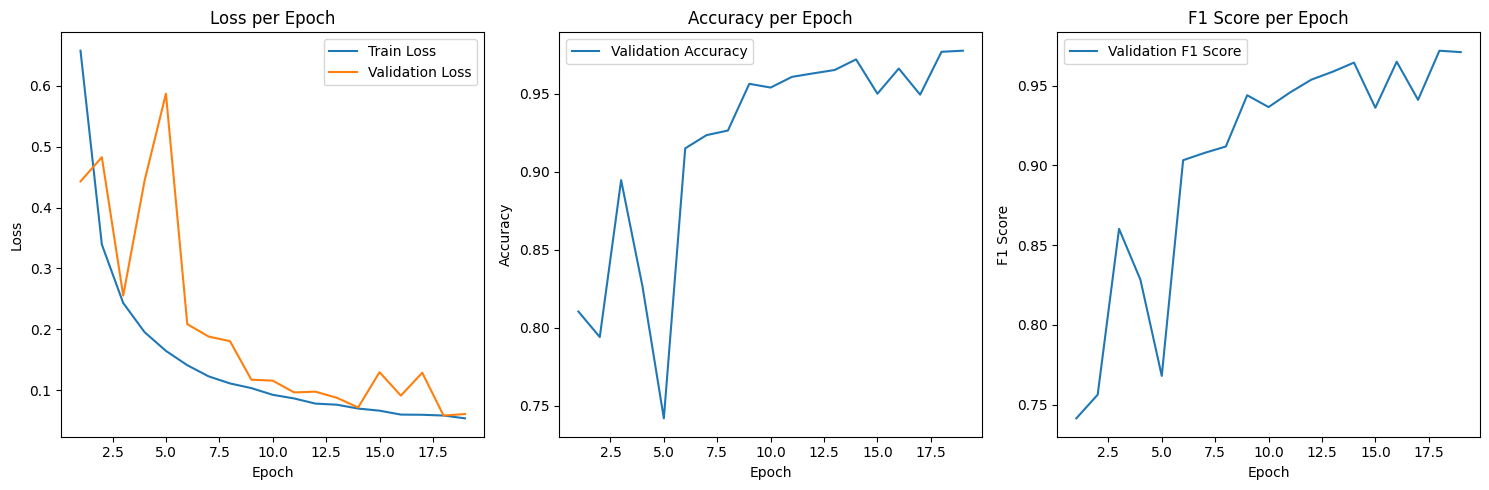

In [48]:
mergedDict = merge_and_plot('DebuggedModelCheckpoints/SimpleCNN/interrupted_performance_0_19.json',"DebuggedModelCheckpoints/SimpleCNN/interrupted_performance_18_24.json")

# Adversarial Training of the SimpleCNN Model

We proceed to train the `SimpleCNN` using the adversarial training function defined earlier. This training aims to improve the model's robustness against adversarial attacks by incorporating adversarial examples generated through the FGSM method. The process involves specifying the model, the training and validation data loaders, the device to use for training (GPU or CPU), and other training parameters such as the number of epochs and epsilon values for adversarial example generation.

In this setup, we resume training from a specific epoch, leveraging a pretrained model state to ensure continuity and efficiency in the training process. The `train_model_with_adversarial` function is utilized, targeting to enhance the model's defense mechanism against adversarial attacks gradually. Performance metrics such as training loss, validation loss, and accuracies are tracked and printed to evaluate the model's effectiveness in learning from both clean and adversarial data.


In [62]:
def fgsm_attack(model, images, labels, epsilon, criterion):
    """Generates adversarial examples using the Fast Gradient Sign Method (FGSM)."""
    images.requires_grad = True
    outputs = model(images)
    model.zero_grad()
    loss = criterion(outputs, labels)
    loss.backward()
    data_grad = images.grad.data
    perturbed_image = images + epsilon * data_grad.sign()
    perturbed_image = torch.clamp(perturbed_image, 0, 1)  # ensure the perturbed images are still valid
    return perturbed_image


def train_model_with_adversarial(model, train_loader, val_loader, device, model_checkpoint_path, model_name, epochs=5, start_epsilon=0.01, end_epsilon=0.3, load_pretrained=True, last_epoch=0):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters())

    # Metrics initialized for multiclass on the correct device
    val_f1_score = torchmetrics.F1Score(num_classes=4, average='macro', task='multiclass').to(device)
    val_accuracy = torchmetrics.Accuracy(num_classes=4, task='multiclass').to(device)

    best_val_loss = float('inf')
    best_val_accuracy = 0
    best_epoch = last_epoch

    train_loss_history = []
    train_accuracy_history = []
    train_f1score_history = []
    val_loss_history = []
    val_accuracy_history = []
    val_f1score_history = []

    model_save_dir = os.path.join(model_checkpoint_path, model_name)
    os.makedirs(model_save_dir, exist_ok=True)

    if load_pretrained and os.path.exists(os.path.join(model_save_dir, f'adv_epoch_{last_epoch}.pth')):
        model.load_state_dict(torch.load(os.path.join(model_save_dir, f'adv_epoch_{last_epoch}.pth'), map_location=device))
        print(f"Loaded pretrained model from {model_save_dir}")

    try:
        for epoch in range(last_epoch, last_epoch + epochs):
            epsilon = start_epsilon + (end_epsilon - start_epsilon) * ((epoch - last_epoch) / epochs)
            model.train()
            total_train_loss = 0

            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()

                # Generate adversarial images
                perturbed_images = fgsm_attack(model, images, labels, epsilon, criterion)

                # Forward pass
                outputs = model(perturbed_images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                total_train_loss += loss.item()

                _, predicted = outputs.max(1)
                val_f1_score.update(predicted, labels)
                val_accuracy.update(predicted, labels)

            avg_train_loss = total_train_loss / len(train_loader)
            train_loss_history.append(avg_train_loss)
            train_accuracy_history.append((predicted == labels).float().mean().item())
            train_f1score_history.append(val_f1_score.compute().item())

            # Validation phase
            model.eval()
            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    val_loss = criterion(outputs, labels)

                    val_loss_history.append(val_loss.item())
                    _, predicted = outputs.max(1)
                    val_accuracy.update(predicted, labels)
                    val_f1_score.update(predicted, labels)

                avg_val_loss = torch.tensor(val_loss_history).mean().item()
                val_accuracy_val = val_accuracy.compute().item()
                val_f1score_val = val_f1_score.compute().item()
                val_accuracy_history.append(val_accuracy_val)
                val_f1score_history.append(val_f1score_val)

            print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_train_loss:.4f}, Acc: {val_accuracy_val:.4f}, F1: {val_f1score_val:.4f}')

            # Save the best model based on validation loss
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                save_model_checkpoint(model, model_save_dir, f'best_model_{epoch}.pth')

    except KeyboardInterrupt:
        print("Training interrupted, saving current state...")
        performance_data = {
            'train_loss': train_loss_history,
            'train_accuracy': train_accuracy_history,
            'train_f1score': train_f1score_history,
            'val_loss': val_loss_history,
            'val_accuracy': val_accuracy_history,
            'val_f1score': val_f1score_history
        }
        handle_keyboard_interrupt(model, model_save_dir, performance_data, last_epoch, epoch,adv=True)

    # Final save after training completion
    performance_data = {
        'train_loss': train_loss_history,
        'train_accuracy': train_accuracy_history,
        'train_f1score': train_f1score_history,
        'val_loss': val_loss_history,
        'val_accuracy': val_accuracy_history,
        'val_f1score': val_f1score_history
    }
    save_performance_metrics(performance_data, model_save_dir, 'final_adv_performance_metrics.json')

    return {
        'model_name': model_name,
        'best_epoch': best_epoch,
        'train_loss_history': train_loss_history,
        'train_accuracy_history': train_accuracy_history,
        'train_f1score_history': train_f1score_history,
        'val_loss_history': val_loss_history,
        'val_accuracy_history': val_accuracy_history,
        'val_f1score_history': val_f1score_history
    }


In [59]:
model_checkpoint_path = 'DebuggedModelCheckpoints'
model_name = 'SimpleCNN'

# Initialize the model
simpleCNN2 = SimpleCNN()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
simpleCNN2.load_state_dict(torch.load(os.path.join(model_checkpoint_path,model_name, 'epoch_17.pth'), map_location=device))

# Train the model
adv_performance_indicators = train_model_with_adversarial(simpleCNN2, 
                                                      train_loader, 
                                                      val_loader, 
                                                      device, 
                                                      model_checkpoint_path, 
                                                      model_name, 
                                                      epochs=30, 
                                                      start_epsilon=0.10, 
                                                      end_epsilon=0.3, 
                                                      load_pretrained=False, 
                                                      last_epoch=0)
print(adv_performance_indicators)

Epoch 1/30, Loss: 1.0725, Acc: 0.6297, F1: 0.6297
Model saved to DebuggedModelCheckpoints/SimpleCNN/best_model_0.pth
Epoch 2/30, Loss: 0.6423, Acc: 0.6938, F1: 0.6976
Epoch 3/30, Loss: 0.4964, Acc: 0.7373, F1: 0.7416
Epoch 4/30, Loss: 0.4080, Acc: 0.7655, F1: 0.7701
Epoch 5/30, Loss: 0.3451, Acc: 0.7890, F1: 0.7933
Epoch 6/30, Loss: 0.3041, Acc: 0.8075, F1: 0.8116
Epoch 7/30, Loss: 0.2858, Acc: 0.8214, F1: 0.8254
Epoch 8/30, Loss: 0.2594, Acc: 0.8331, F1: 0.8370
Epoch 9/30, Loss: 0.2480, Acc: 0.8426, F1: 0.8464
Epoch 10/30, Loss: 0.2320, Acc: 0.8503, F1: 0.8541
Epoch 11/30, Loss: 0.2301, Acc: 0.8573, F1: 0.8610
Epoch 12/30, Loss: 0.2205, Acc: 0.8631, F1: 0.8668
Epoch 13/30, Loss: 0.2167, Acc: 0.8682, F1: 0.8719
Epoch 14/30, Loss: 0.2136, Acc: 0.8726, F1: 0.8762
Epoch 15/30, Loss: 0.2054, Acc: 0.8767, F1: 0.8803
Epoch 16/30, Loss: 0.1979, Acc: 0.8802, F1: 0.8838
Epoch 17/30, Loss: 0.1920, Acc: 0.8835, F1: 0.8872
Epoch 18/30, Loss: 0.1882, Acc: 0.8866, F1: 0.8902
Epoch 19/30, Loss: 0.187

NameError: name 'valuracy_history' is not defined

In [60]:
model_checkpoint_path = 'DebuggedModelCheckpoints'
model_name = 'SimpleCNN'

# Initialize the model
simpleCNN2 = SimpleCNN()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Train the model
adv_performance_indicators = train_model_with_adversarial(simpleCNN2, 
                                                      train_loader, 
                                                      val_loader, 
                                                      device, 
                                                      model_checkpoint_path, 
                                                      model_name, 
                                                      epochs=30, 
                                                      start_epsilon=0.30, 
                                                      end_epsilon=0.31, 
                                                      load_pretrained=False, 
                                                      last_epoch=29)
print(adv_performance_indicators)

Epoch 30/30, Loss: 0.5270, Acc: 0.7739, F1: 0.7751
Model saved to DebuggedModelCheckpoints/SimpleCNN/best_model_29.pth
Epoch 31/30, Loss: 0.1698, Acc: 0.8347, F1: 0.8392
Epoch 32/30, Loss: 0.1423, Acc: 0.8702, F1: 0.8737
Model saved to DebuggedModelCheckpoints/SimpleCNN/best_model_31.pth
Epoch 33/30, Loss: 0.1285, Acc: 0.8872, F1: 0.8905
Model saved to DebuggedModelCheckpoints/SimpleCNN/best_model_32.pth
Epoch 34/30, Loss: 0.1209, Acc: 0.9000, F1: 0.9030
Model saved to DebuggedModelCheckpoints/SimpleCNN/best_model_33.pth
Epoch 35/30, Loss: 0.1179, Acc: 0.9066, F1: 0.9097
Model saved to DebuggedModelCheckpoints/SimpleCNN/best_model_34.pth
Epoch 36/30, Loss: 0.1114, Acc: 0.9122, F1: 0.9152
Model saved to DebuggedModelCheckpoints/SimpleCNN/best_model_35.pth
Epoch 37/30, Loss: 0.1129, Acc: 0.9180, F1: 0.9208
Model saved to DebuggedModelCheckpoints/SimpleCNN/best_model_36.pth
Epoch 38/30, Loss: 0.1071, Acc: 0.9229, F1: 0.9255
Model saved to DebuggedModelCheckpoints/SimpleCNN/best_model_37.p

NameError: name 'valuracy_history' is not defined

# Evaluation Model Performance (Test)

In [65]:
import os
import torch
from torch import nn
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np  # Import numpy for calculations

def validate(model, model_save_dir, modelName, last_epoch, val_loader, device, num_classes, adv=False):
    model.to(device)
    version = 'Adversarial' if adv else 'Standard'
    if adv: 
        model_save_path = os.path.join(f'{model_save_dir}/{modelName}', f'best_model_{last_epoch}.pth')
    else: 
        model_save_path = os.path.join(f'{model_save_dir}/{modelName}', f'epoch_{last_epoch}.pth')

    if os.path.isfile(model_save_path):
        model.load_state_dict(torch.load(model_save_path, map_location=device))
    else:
        print(f"No pretrained model found at {model_save_path}.")
        return

    criterion = nn.CrossEntropyLoss()
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.view(-1).cpu().numpy())
            all_labels.extend(labels.view(-1).cpu().numpy())

    # Compute the metrics
    val_loss /= len(val_loader)
    val_accuracy = val_correct / val_total
    f1_macro = f1_score(all_labels, all_preds, average='macro')

    # Print the results
    print(f'{version} Model - Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}, F1 Macro: {f1_macro:.4f}')

    # Calculate and normalize the confusion matrix
    cm = confusion_matrix(all_labels, all_preds, labels=list(range(num_classes)))
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalize each row to sum to 1

    print('Confusion Matrix:')
    # print(cm_percentage)  # Display the percentage matrix

    # Plot the confusion matrix using seaborn
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm_percentage, annot=True, fmt=".2%", cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Confusion Matrix for {version} Model')
    plt.show()

    return

Training Set Evaluation:
Standard Model - Loss: 0.0538, Accuracy: 0.9805, F1 Macro: 0.9805
Confusion Matrix:


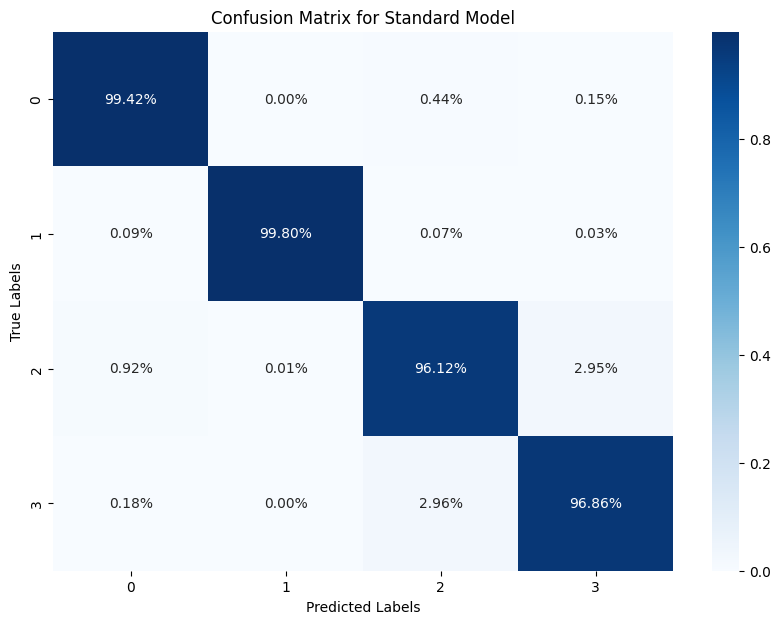

Validation Set Evaluation:
Standard Model - Loss: 0.0582, Accuracy: 0.9768, F1 Macro: 0.9718
Confusion Matrix:


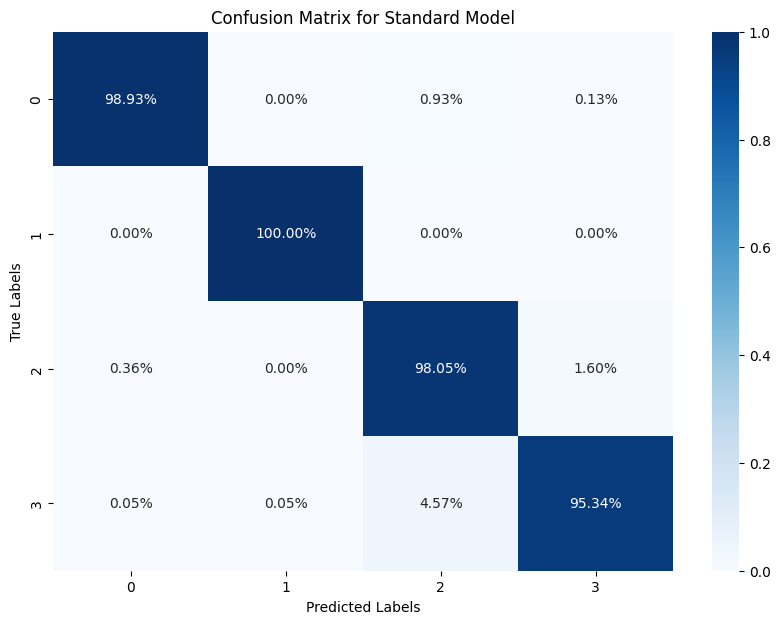

Test Set Evaluation:
Standard Model - Loss: 0.0558, Accuracy: 0.9783, F1 Macro: 0.9704
Confusion Matrix:


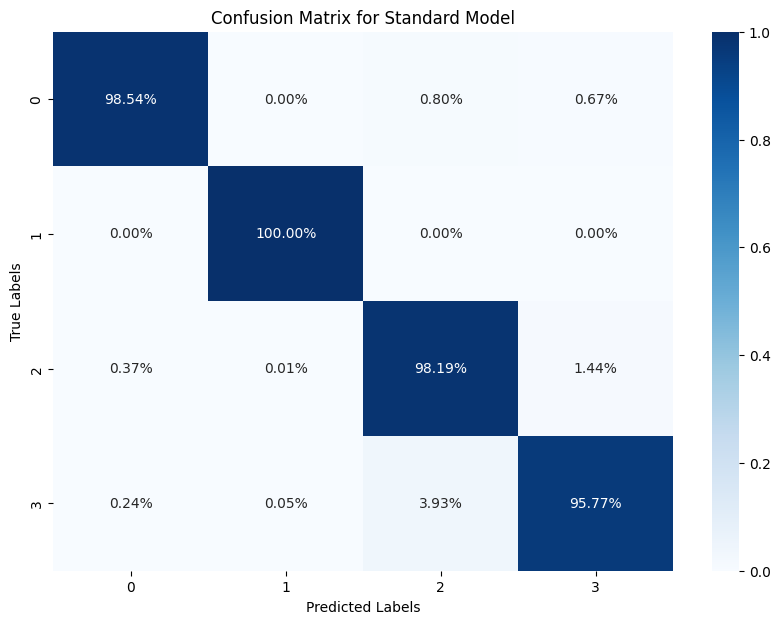

In [54]:
model_checkpoint_path = 'DebuggedModelCheckpoints'
model_name = 'SimpleCNN'

# Initialize the model
simpleCNN = SimpleCNN()
device = torch.device("cuda" if torch.cuda.is_available() else "CPU")

# Validate and print results
print("Training Set Evaluation:")
validate(simpleCNN, model_checkpoint_path, model_name, 17, train_loader,device,4, adv=False)
print("Validation Set Evaluation:")
validate(simpleCNN, model_checkpoint_path, model_name, 17, val_loader,device,4, adv=False)
print("Test Set Evaluation:")
validate(simpleCNN, model_checkpoint_path, model_name, 17, test_loader,device,4, adv=False)

## Adversial trained Model Performance

The adverserial training has not been throughly completed till convergence due to time constraints, however a continued training will most yeild results closer to the original performance of the model. 

Training Set Evaluation:
Adversarial Model - Loss: 0.2734, Accuracy: 0.8934, F1 Macro: 0.8934
Confusion Matrix:


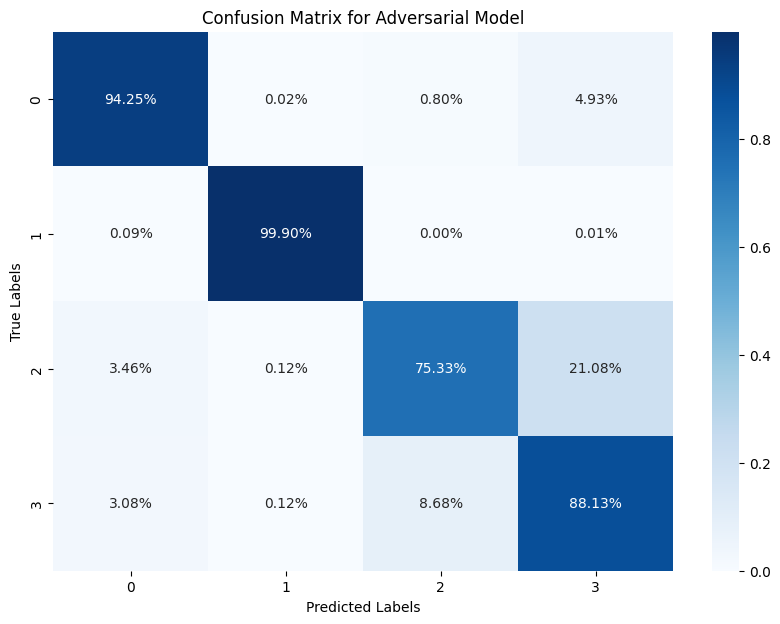

Validation Set Evaluation:
Adversarial Model - Loss: 0.4761, Accuracy: 0.7814, F1 Macro: 0.7656
Confusion Matrix:


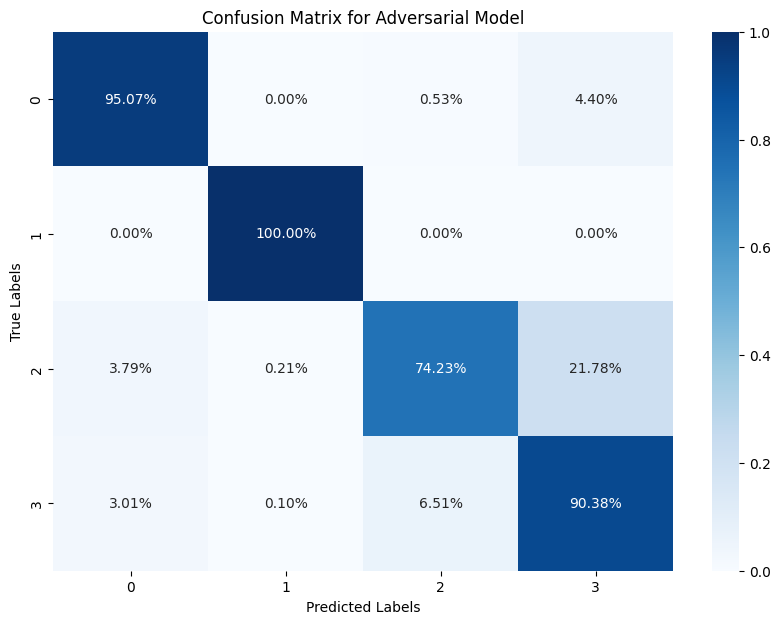

Test Set Evaluation:
Adversarial Model - Loss: 0.4867, Accuracy: 0.7776, F1 Macro: 0.7750
Confusion Matrix:


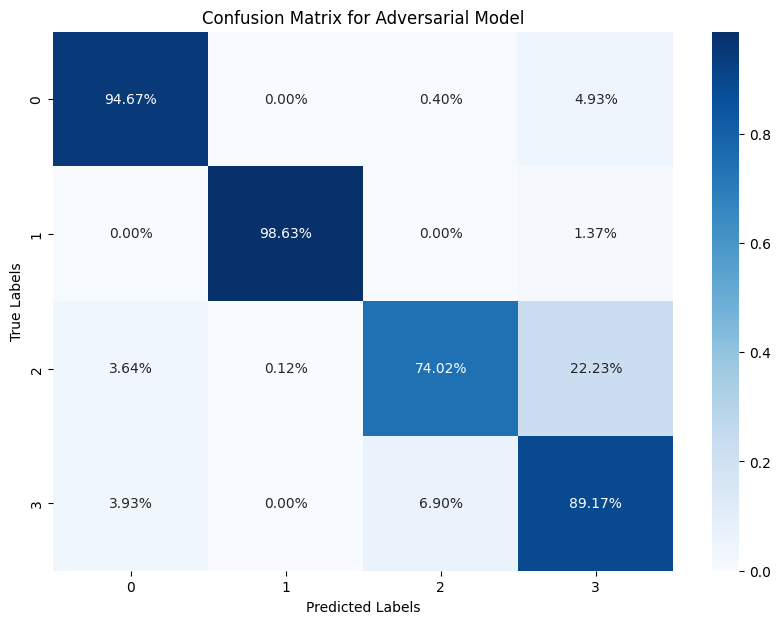

In [66]:
model_checkpoint_path = 'DebuggedModelCheckpoints'
model_name = 'SimpleCNN'

# Initialize the model
simpleCNN = SimpleCNN()
device = torch.device("cuda" if torch.cuda.is_available() else "CPU")

# Validate and print results
print("Training Set Evaluation:")
validate(simpleCNN, model_checkpoint_path, model_name, 58, train_loader,device,4, adv=True)
print("Validation Set Evaluation:")
validate(simpleCNN, model_checkpoint_path, model_name, 58, val_loader,device,4, adv=True)
print("Test Set Evaluation:")
validate(simpleCNN, model_checkpoint_path, model_name, 58, test_loader,device,4, adv=True)

# Calculate total model parameters

### Failed model

In [20]:
cnn = CNN2()
cnn.load_state_dict(torch.load('ModelCheckpoints/CNN2/epoch_1.pth',map_location=torch.device('cpu')))
trainable_params = sum(p.numel() for p in cnn.parameters() if p.requires_grad)
print(f"Total trainable parameters: {trainable_params}")

Total trainable parameters: 223497


### simpleCNN

In [61]:
simpleCNN = SimpleCNN()
simpleCNN.load_state_dict(torch.load('DebuggedModelCheckpoints/SimpleCNN/epoch_17.pth',map_location=torch.device('cpu')))
trainable_params = sum(p.numel() for p in simpleCNN.parameters() if p.requires_grad)
print(f"Total trainable parameters: {trainable_params}")

Total trainable parameters: 454530
